# OpenPack Challenge | Tutorial: OpenPack Datasetの概要とモデリングの考え方

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-pack/openpack-torch/blob/main/examples/deep-conv-lstm/notebooks/Tutorial_Basics_of_Modeling__JA.ipynb)

NOTE: colabで実行する場合は，実行前にランタイムを "GPU" に変更してください．

NOTE: このNotebookにはコンペに提出する`submission.json`を作成するための手順は含まれていません．他のチュートリアルを参考にしてください．

## [1] はじめに

このノートブックは， [Percom 2023 Workshop　BiRD](https://bio-navigation.jp/bird2023/) で開催される行動認識コンペティション 「[OpenPack Challenge　2022](https://open-pack.github.io/challenge2022)」の参加者用チュートリアルとして作成しました．
このチュートリアルでは， (1) OpenPackの概要とタスクの説明， (2) 行動認識モデルのサンプルプログラムの実行を行います．
OpenPackデータセットのデータの性質を捉え， 梱包作業という作業行動を認識するためのモデリングの考え方を学んで行きましょう．

### 1-1: OpenPack Challenge 2022 (データ分析コンペティション)

[Percom 2023 Workshop](https://bio-navigation.jp/bird2023/)で，OpenPack Datasetを使用したデータ分析コンペの開催を予定しています． 
コンペのタスクはこのノートブックで説明するものと同じく， 10種類の作業工程の分類 (temporal semantic segmentation) です．
コンペの詳細につきましては [HP](https://open-pack.github.io/challenge2022) をご参照ください．
また，　このチュートリアルを通して作業工程の認識に興味を持っていただけましたら，　ぜひコンペへの参加もご検討いただけると嬉しく思います．

- [OpenPack Challenge 2022 - Official Site](https://open-pack.github.io/challenge2022)
- [Google Group](https://groups.google.com/g/openpack) (コンペの最新情報を受け取りたい方は，こちらのメーリングリストにご登録ください．)

![](../../assets/img/OpenPackCHALLENG-black.png)

### 1-2: このチュートリアルの学習対象者

- OpenPack Challengeの参加者または参加を検討している方
- OpenPack Datasetの概要を把握したい方
- 機械学習 (Neural Network) のモデリングの基礎に触れたい方

このチュートリアルを実行するにあたって，高度な機械学習の知識は必要としませんが，　機械学習の基本に関しては知識があることが望ましいです．

## [2] OpenPack Datasetの概要

**OpenPack Dataset**は， 産業ドメインにおける大規模マルチモーダルデータセットです．
物流センターの梱包作業に注目し， 16名の被験者が商品を段ボールに梱包する作業を， 深度センサやIMUセンサなど 9種類のセンサーで記録しました．
データセットのサイズは53時間超であり，産業ドメインのデータセットでは最大級です．

OpenPackの特徴を簡単にまとめました．　詳細は[HP](https://open-pack.github.io)を参照してください．

> **OpenPack Datasetの特徴**
> 1. 合計53時間を超える大規模な，産業ドメインの行動認識データセット．
> 1. 9種類のセンサの種類に加え， スマート工場に導入されているIoT機器のデータを含む．
> 1. 作業者の梱包作業の経験や， 梱包する商品など豊富なメタデータを収集．

OpenPack Datasetは，行動認識研究のためのデータセットであり，　以下の10種類の作業工程に対してラベルが付与されています(下図のAnnotation/Operationの段)．
このノートブックでは， 与えられたセンサデータに対して1秒単位でどの行動が行われているかを推定します．
[Youtube](https://youtu.be/KRG5zv3ueRQ) にサンプル動画 (深度画像)をアップロードしています． こちらを見ていただければ，梱包作業の具体的な流れが掴めると思います．

> **OpenPack: Activity Class (作業工程)**
> - 100: Picking (梱包する商品を持ってくる.)
> - 200: Relocate Item Label (商品についているラベルを梱包リストに張り替える.)
> - 300: Assemble Box (段ボールを組み立てる.)
> - 400: Insert Items (組み立てた段ボールに商品を詰める.)
> - 500: Close Box (段ボールを閉じる.)
> - 600: Attach Box Label (箱番号シールを貼り付ける.)
> - 700: Scan Label (複数のバーコードをスキャンする.)
> - 800: Attaching Shipping Label (出荷ラベルをつける.)
> - 900: Put on Back Table (梱包した箱を後ろのテーブルに片付ける.)
> - 1000: Fill out Order (梱包リストの確認欄を記入し， 片付ける.)

OpenPack Datasetの主なタスクは 「梱包作業における作業工程の認識」です．
しかし，その認識は簡単ではありません．
例えば，「Walk」を認識したい場合は，手足の周期的な動きを捉えれば良いですが，作業工程の場合繰り返される動きが非常に少ない上，以下のような課題にも対処する必要があります．

1. 被験者の熟練度によって，動作のスピードが大きく異なります．
1. 梱包する商品の組み合わせが毎回異なります． 商品のサイズによって使用する箱のサイズも変わります． さらに，商品の数が異なれば，箱に入れる動作の回数が変わります．
1. 作業の手順は基本的に決まっていますが，より効率的な作業のために熟練者は手順を一部変更したり， 間違いによって順番が変更されます．

![](../../assets/img/OpenPack__KeyVisual.png)

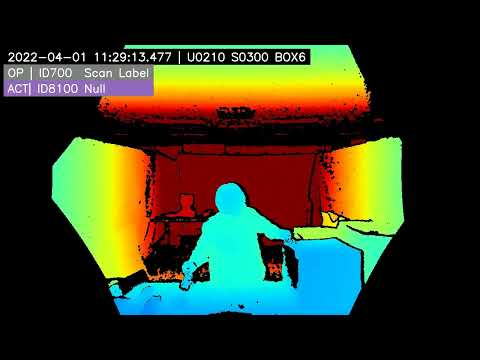

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('KRG5zv3ueRQ', width=600, height=400)

## [3] 行動認識のサンプルプログラムの実行

ここから先では， 左右の手首に装着したIMUセンサーで収集した加速度データを入力として， 1秒単位で10種類の作業工程のどれが行われているかを推定する Neural Networkの構築を行います．
ここでは，モデリングの基本アイデアを学ぶことに注目してほしいので，学習に必要なコードは複数ありますが，特に指示がないところはそのまま実行してください．
データの前処理や学習方法の変更などの発展的な実験に挑戦したい場合は，別のチュートリアルで理解を深めていただけると幸いです．

- 入力: 左右手首から30Hzで収集した加速度信号 60秒 (入力するTensorのShape: `(1800, 6)`)
- 出力: 1秒後ごとの作業工程ラベル (TensorのShape: `(60, 10)`)
- モデル: Neural Network (PyTorch)

![](../../assets/img/tutorial/task_JA.jpg)

### Neural Networkとは？

人間の神経細胞から着想を得た，機械学習モデルの一つです．
最初はランダムな値を主力しますが，入力データと正解ラベルの関係を「学習」することで，高精度で予測ができるようになります．

### 行動認識モデルのモデリング

ここでは，行動認識モデルを構成するためにどのような視点を持てば良いかということを簡単にまとめます．
具体的な実装や選択は下のサンプルを実行しながら説明します．
まず，マルチモーダルな時系列データを扱うにあたって，考えるべきことの例を以下にまとめました．

1. 時間方向の依存関係
    1. 考慮する範囲 (1秒間?，10秒間?) ... 認識対象の行動の継続時間などを参考に設定します．
    1. 順方向の時間発展 (時間を進める方向) のみ考慮するか，逆方向 (時間を巻き戻す方向)も考慮するか?　... 「タップ」と「ダブルタップ」を分類するとき， 1回目のタップがどちらか見分けるためには過去と未来両方から攻める必要があります．
1. モダリティの扱い
    1. センサーフュージョン (両手の動きをまとめて特徴抽出する? OR 右左別々に特徴抽出を行なったあとで組み合わせる？) ... 左右の手は独立に動くことができるので，分けて考えた方が効果的な場合があります．
    1. 他のモダリティ (動画，IoT デバイスのログ, etc) との組み合わせ方


このチュートリアルで全てを扱うことは難しいので，**1. 時間方向の依存関係** について考えていきたいと思います．

### OpenPack Datasetの梱包作業に着目したモデリングのポイント

基本的には上の2項目と同じですが，よりOpenPack Datasetに特化したポイントを説明します．

- 手だけを使った動作が中心です．そのため，加速度データだけでは非常に似通った動作が多く存在します．
    - e.g.) 腕の移動, Assemble Box と Close Box
    - 特徴抽出する範囲をできるだけ広くとって，**前後の作業工程を手がかりに注目した時刻の動作を推定**することが有効だと考えられます．
- 行動の出現順序は基本的に決まっています．
    - 作業手順が決まっているため，行動クラスの出現順序もおおよそ決まっています．
    - この**行動の出現順序は予測を行う上で大きなヒント**となります．
    - (注意) ある程度精度が高まると，作業ミスなどで通常の順序から外れる場合の誤認識が課題となります．　より精度を高めるためには．この部分をどう扱うかがより精度を高めるために重要になります．

![](../../assets/img/tutorial/work_HAR_idea_JA.jpg)

------
ここからは，実装パートになります．

## [4] 環境の初期化 (Notebookを開いて初回のみ実行)
細かい説明は省きます．ひとまず，以下のコードを順番に実行してください．

### 4-1: Download Code and Install `openpack-torch` 

In [ ]:
# サンプルコードのダウンロード
! cd /content && git clone https://github.com/open-pack/openpack-torch.git

In [ ]:
# 関連パッケージのダウンロード
! cd /content/openpack-torch/ && pip install .

### 4-2: データセットのダウンロード

NOTE: Colabを使用している場合は，このセルを実行しGoogle Driveをマウントする．

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

データセットのダウンロード (ダウンロード先: `/content/drive/MyDrive/Colab Notebooks/openpack/data/datasets`)

In [ ]:
# NOTE: If you have already downloaded the dataset, you can skip this cell.
! mkdir -p "/content/drive/MyDrive/Colab Notebooks/openpack/data/datasets"
! wget https://raw.githubusercontent.com/open-pack/openpack-toolkit/main/tools/download/dl_from_zenodo.sh
! bash ./dl_from_zenodo.sh "/content/drive/MyDrive/Colab Notebooks/openpack/data/datasets"

In [ ]:
! ln -s "/content/drive/MyDrive/Colab Notebooks/openpack/data/" "/content/data"

In [1]:
! ls -la "/content/data/datasets/openpack/v1.0.0"

total 100
drwxrwsr-x 25 1001 240 4096 Nov 19 11:21 .
drwxrwsr-x  3 1001 240 4096 Nov 19 09:56 ..
drwxrwsr-x  7 1001 240 4096 Nov 19 10:06 U0101
drwxrwsr-x  7 1001 240 4096 Nov 19 10:09 U0102
drwxrwsr-x  7 1001 240 4096 Nov 19 10:12 U0103
drwxrwsr-x  7 1001 240 4096 Nov 19 10:16 U0104
drwxrwsr-x  7 1001 240 4096 Nov 19 10:19 U0105
drwxrwsr-x  7 1001 240 4096 Nov 19 10:24 U0106
drwxrwsr-x  7 1001 240 4096 Nov 19 10:28 U0107
drwxrwsr-x  7 1001 240 4096 Nov 19 10:32 U0108
drwxrwsr-x  7 1001 240 4096 Nov 19 10:37 U0109
drwxrwsr-x  7 1001 240 4096 Nov 19 10:41 U0110
drwxrwsr-x  7 1001 240 4096 Nov 19 10:46 U0111
drwxrwsr-x  7 1001 240 4096 Nov 19 10:49 U0201
drwxrwsr-x  7 1001 240 4096 Nov 19 10:53 U0202
drwxrwsr-x  7 1001 240 4096 Nov 19 10:56 U0203
drwxrwsr-x  7 1001 240 4096 Nov 19 11:00 U0204
drwxrwsr-x  7 1001 240 4096 Nov 19 11:05 U0205
drwxrwsr-x  7 1001 240 4096 Nov 19 11:08 U0206
drwxrwsr-x  7 1001 240 4096 Nov 19 11:11 U0207
drwxrwsr-x  7 1001 240 4096 Nov 19 11:14 U0208
drwxrwsr-x

### 4-3: モジュールのインポート

In [1]:
import logging
from logging import getLogger
from pathlib import Path
from typing import Dict, Optional

import hydra
import openpack_toolkit as optk
import pytorch_lightning as pl
import torch
import pandas as pd
import numpy as np
from omegaconf import DictConfig, OmegaConf
from scipy.special import softmax
from torch import nn

import matplotlib.pyplot as plt
import seaborn as sns

import openpack_torch as optorch
from openpack_torch.lightning import EarlyStopError
from openpack_torch.utils.test_helper import test_helper

from openpack_toolkit import ActSet
from openpack_toolkit.configs.datasets.annotations import (
    OPENPACK_ACTIONS,
    OPENPACK_OPERATIONS,
)
from openpack_toolkit.codalab.operation_segmentation import (
    construct_submission_dict, eval_operation_segmentation_wrapper,
    make_submission_zipfile)

sns.set("notebook", "whitegrid")

In [2]:
_ = optk.utils.notebook.setup_root_logger()
logger = logging.getLogger(__name__)

logger.debug("debug")
logger.info("info")
logger.warning("warning")

2023-11-23 09:00:59 | INFO | __main__ | info
2023-11-23 09:00:59 | WARNING | __main__ | warning


In [3]:
optorch.utils.reset_seed(seed=0)
optorch.configs.register_configs()

2023-11-23 09:00:59 | INFO | openpack_torch.utils.random | Reset Seeds: python=0, numpy=0, Pytorch (cpu=0, cuda=0)


### 4-4: 設定ファイルの読み込み
パラメータなどのデフォルト値を読み込みます．こちらも詳細な説明は省きます．深層学習でモデルを組む場合は，非常に多くのハイパーパラメータ (手動で設定すべきパラメータ) があるため，これらを管理することは実験の再現性と効率を高めるために重要です．この問題を解決するために様々なツールが提案されていますが，ここでは　[hydra](https://hydra.cc/) を使用しています．

In [4]:
# Config Fileのサンプルをコピー
! cp -r /content/openpack-torch/examples/configs /content/

In [5]:
overrides = [
    "mode=train",
    "metadata.labels.issue=I01-EXP1-V1-nb", # subdirectry for logging
    
    # -- debug --
    # If true, some training parameters (e.g., bach size, epochs) are switched to debug mode setting written in `train.debug.XXX`.
    "debug=true",

    # -- path.logdir.rootdir --
    "path.openpack.version=v1.0.0",
    "path.openpack.rootdir=/content/data/datasets/openpack/${path.openpack.version}/",
    
    # -- path.logdir.rootdir --
    # path to write training logs and resutls.
    # If you want to keep logs, please use Google Drive (i.e., `/content/data/XXX` (symling to Google Drive), `/content/drive/XXX`)
    "path.logdir.rootdir=/content/data/log/${metadata.name}/${metadata.labels.issue}/${metadata.task}/${dataset.split.name}-split/${dataset.stream.name}/${model.name}/${metadata.labels.params}/RUN${run}",
    
    # "hydra/job_logging=custom",
    # "hydra/hydra_logging=disabled"
]

with hydra.initialize_config_dir(version_base=None, config_dir="/content/configs"):
    cfg = hydra.compose(
        config_name="deep-conv-lstm.yaml",
        overrides=overrides,
    )

# -- Data Split --
# Change Train/Val/Test/Submission set to submit for Development Phase.
# Please comment out the following block when you want to train on the main set.
# cfg.dataset.split = optk.configs.datasets.splits.DEBUG_SPLIT
cfg.dataset.split = optk.configs.datasets.splits.PILOT_CHALLENGE_SPLIT

# (default value)
# cfg.dataset.split = optk.configs.datasets.splits.OPENPACK_CHALLENGE_2022_SPLIT

In [6]:
print(OmegaConf.to_yaml(cfg))

run: 0
debug: true
mode: train
path:
  openpack:
    version: v1.0.0
    rootdir: /content/data/datasets/openpack/${path.openpack.version}/
  datasets:
    openpack: ${path.openpack.rootdir}
  logdir:
    rootdir: /content/data/log/${metadata.name}/${metadata.labels.issue}/${metadata.task}/${dataset.split.name}-split/${dataset.stream.name}/${model.name}/${metadata.labels.params}/RUN${run}
    model: ${path.logdir.rootdir}/model.pth
    predict: ${path.logdir.rootdir}/pred/${train.checkpoint}/{user}-{session}
    summary:
      rootdir: ${path.logdir.rootdir}/summary/${train.checkpoint}
      train: ${.rootdir}/train.csv
      test: ${.rootdir}/test.csv
      test-b2: ${.rootdir}/test-b2.csv
      test-b3: ${.rootdir}/test-b3.csv
      submission: ${.rootdir}/submission.csv
dataset:
  annotation:
    kind: dataset/annotation/csv/sequence
    name: openpack-operations-1hz-annotation
    metadata:
      labels:
        type: annotation/operation
        version: v3.5.0
        dependency:

## [5] モデルの定義

### 5-1: ベースとするモデルの概要 (DeepConvLSTM)

このチュートリアルでは，DeepConvLSTM という2016年に発表されたモデルをベースに，様々なモデルを作っていきたいと思います．
このモデルは，現在でもベースライン手法として多くの研究で利用されています．
まず，畳み込み層 (convolution layer) で局所的な特徴を抽出した後，LSTM層で長期的な依存関係を抽出することで，短期的な依存関係と長期的な依存関係の両方を考慮するように設計されています．

参考: [Deep Convolutional and LSTM Recurrent Neural Networks for Multimodal Wearable Activity Recognition (Sensors, 2016)](https://www.mdpi.com/1424-8220/16/1/115) 

### 5-2: モデルの変更パターン

今回は次の3種類を用意しました．

1. CNNのみ
    1. 畳み込みフィルタのサイズを変更して，特徴を抽出する時間の長さを変える.
    1. CNN層の数を変える.
1. DeepConvLSTM (論文で提案されているモデル)
1. 双方向LSTM (LSTM層を，順方向&逆方向の両方を考慮するものを使用)


![](../../assets/img/tutorial/dcl_architecture_JA.jpg)

### 5-3: CNNのみ (ver.1) 

CNNのみを使用したモデルです．
特徴を抽出する時間の範囲は，(A) kernel size，(B) 畳み込み層の数を変更することで変えることができます．
畳み込み層はPyTorchで `Conv2d()` として定義されています．

#### 実験1-A: Kernel Sizeの変更

センサーのサンプリングレートは30Hzです．
つまり，Kernel Sizeを `ks=30` とすると，一回の畳み込み演算で1秒間の範囲から特徴抽出をすることができます．
実験では，以下の値に設定してモデルを学習してみて結果を比べてみましょう．
ちなみに，OpenPackの作業工程の継続時間は作業工程により異なりますが，通常2秒 ~ 15秒です．

- `ks=5` (0.16秒間; 論文のパラメータ)
- `ks=15` (0.5秒間)
- `ks=30` (1.0秒間)
- `ks=60` (2.0秒間)


#### 実験1-B: 畳み込み層の数 (`num_conv_layers`)

畳み込み層を重ねることでも，特徴抽出の範囲を広げることができます．
以下の値を試してみてください．

- `num_conv_layers = 1`
- `num_conv_layers = 4` (論文のパラメータ)
- `num_conv_layers = 8`


#### 実験1-C: Kernel Size x 畳み込み層の数

「Kernel Size」と「畳み込み層の数」はどちらも特徴を抽出する範囲を変えることができます．
また，この２つのパラメータの組み合わせ方もとても重要です．
例えば，kernel sizeは小さく，層の数は多く設定することで，細かな特徴を捉えつつ徐々に長期的な依存関係を捉えることができます．
画像系のモデルでは，しばしばこのアプローチが採用されてきました．
逆に，Kernel Sizeを大きく設定し，層の数を減らすアプローチでは，畳み込む範囲が広いので局所的なノイズに強くすることができます．
どのようなアプローチが良いか，実験してみてください．

![](../../assets/img/tutorial/cnn_receptive_field_JA.jpg)

In [7]:
class DeepConvLstmV1(nn.Module):
    """CNNだけを使用するモデル
    """
    def __init__(self, in_ch: int = 3, num_classes: int = None):
        super().__init__()
        if num_classes is None:
            num_classes = len(OPENPACK_OPERATIONS)

        # -- [1] CNN (畳み込み層) --
        # *** Edit Here ***
        # NOTE: 実験1-A: Kernel Size (注意: 奇数を指定)
        ks = 5
        # NOTE: 実験1-B: 使用する畳み込み層の数 (Default: 4)
        num_conv_layers = 4
        # ******************
        num_conv_filter = 64 # 各層の畳み込みフィルタの数 (Default: 64)
        
        blocks = []
        for i in range(num_conv_layers):
            in_ch_ = in_ch if i == 0 else num_conv_filter 
            blocks.append(
                nn.Sequential(
                    nn.Conv2d(in_ch_, num_conv_filter, kernel_size=(ks, 1), padding=(ks//2, 0)),
                    nn.BatchNorm2d(num_conv_filter),
                    nn.ReLU(),
                )
            )
        self.conv_blocks = nn.ModuleList(blocks)

        # -- [3] 出力層 --
        self.out8 = nn.Conv2d(
            num_conv_filter,
            num_classes,
            1,
            stride=1,
            padding=0,
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x (torch.Tensor): shape = (B, CH, T, 1)
        Returns:
            torch.Tensor: shape = (B, N_CLASSES, T, 1)
        """
        # -- [1] Conv --
        for block in self.conv_blocks:
            x = block(x)
            
        # -- [3] 出力層 --
        x = self.out8(x)
        return x


### 5-4: DeepConvLstm (ver.2)

論文で提案されているモデルの構成です．ver.1に対して，LSTM層が追加されています．
LSTMによって，長期的な依存関係を学習することができるようになります．

In [8]:
class DeepConvLstm(nn.Module):
    """論文で提案されている構成
    """
    def __init__(self, in_ch: int = 3, num_classes: int = None):
        super().__init__()
        if num_classes is None:
            num_classes = len(OPENPACK_OPERATIONS)

        # -- [1] CNN (畳み込み層) --
        # *** Edit Here ***
        num_conv_layers = 4 # 使用する畳み込み層の数 (Default: 4)
        num_conv_filter = 64 # 各層の畳み込みフィルタの数 (Default: 64)
        ks = 5 # 畳み込みフィルタのサイズ; kernel size, 
        # ******************
        
        blocks = []
        for i in range(num_conv_layers):
            in_ch_ = in_ch if i == 0 else 64
            blocks.append(
                nn.Sequential(
                    nn.Conv2d(in_ch_, 64, kernel_size=(5, 1), padding=(2, 0)),
                    nn.BatchNorm2d(64),
                    nn.ReLU(),
                )
            )
        self.conv_blocks = nn.ModuleList(blocks)

        # -- [2] LSTM --
        # *** Edit Here ***        
        hidden_units = 128 # LSTM層の隠れニューロンの数
        # ******************
        
        self.lstm6 = nn.LSTM(num_conv_filter, hidden_units, batch_first=True)
        self.lstm7 = nn.LSTM(hidden_units, hidden_units, batch_first=True)
        self.dropout6 = nn.Dropout(p=0.5)
        self.dropout7 = nn.Dropout(p=0.5)

        # -- [3] 出力層 --
        self.out8 = nn.Conv2d(
            hidden_units,
            num_classes,
            1,
            stride=1,
            padding=0,
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x (torch.Tensor): shape = (B, CH, T, 1)
        Returns:
            torch.Tensor: shape = (B, N_CLASSES, T, 1)
        """
        # -- [1] Conv --
        for block in self.conv_blocks:
            x = block(x)

        # -- [2] LSTM (!! 追加 !!) --
        # Reshape: (B, CH, 1, T) -> (B, T, CH)
        x = x.squeeze(3).transpose(1, 2)

        x, _ = self.lstm6(x)
        x = self.dropout6(x)
        x, _ = self.lstm7(x)
        x = self.dropout7(x)

        # Reshape: (B, T, CH) -> (B, CH, T, 1)
        x = x.transpose(1, 2).unsqueeze(3) 
        
        # -- [3] 出力層 --
        x = self.out8(x)
        return x


### 5-5: DeepConvLstm (ver.3)

ver.2のLSTM層を，双方向 (時間の進む&戻る) の依存関係を考慮する設定に書き換えました．
この変更により，注目した部分の行動の推定を，前の作業工程の情報だけでなく，これから起こる作業工程の情報も考慮して推定することができるようになります．

In [9]:
class DeepConvLstmV3(nn.Module):
    def __init__(self, in_ch: int = 3, num_classes: int = None):
        super().__init__()
        if num_classes is None:
            num_classes = len(OPENPACK_OPERATIONS)

        # -- [1] CNN (畳み込み層) --
        # *** Edit Here ***
        num_conv_layers = 4 # 使用する畳み込み層の数 (Default: 4)
        num_conv_filter = 64 # 各層の畳み込みフィルタの数 (Default: 64)
        ks = 5 # 畳み込みフィルタのサイズ; kernel size, 
        # ******************
        
        blocks = []
        for i in range(num_conv_layers):
            in_ch_ = in_ch if i == 0 else 64
            blocks.append(
                nn.Sequential(
                    nn.Conv2d(in_ch_, 64, kernel_size=(5, 1), padding=(2, 0)),
                    nn.BatchNorm2d(64),
                    nn.ReLU(),
                )
            )
        self.conv_blocks = nn.ModuleList(blocks)

        # -- [2] LSTM --
        # *** Edit Here ***        
        hidden_units = 128 # LSTM層の隠れニューロンの数
        # ******************
        
        # NOTE: bidirectionalをTrueに変更
        self.lstm6 = nn.LSTM(num_conv_filter, hidden_units, batch_first=True, bidirectional=True)
        self.lstm7 = nn.LSTM(hidden_units*2, hidden_units, batch_first=True,  bidirectional=True)
        self.dropout6 = nn.Dropout(p=0.5)
        self.dropout7 = nn.Dropout(p=0.5)

        # -- [3] 出力層 --
        self.out8 = nn.Conv2d(
            hidden_units * 2,
            num_classes,
            1,
            stride=1,
            padding=0,
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x (torch.Tensor): shape = (B, CH, T, 1)
        Returns:
            torch.Tensor: shape = (B, N_CLASSES, T, 1)
        """
        # -- [1] Conv --
        for block in self.conv_blocks:
            x = block(x)

        # -- [2] LSTM --
        # Reshape: (B, CH, 1, T) -> (B, T, CH)
        x = x.squeeze(3).transpose(1, 2)

        x, _ = self.lstm6(x)
        x = self.dropout6(x)
        x, _ = self.lstm7(x)
        x = self.dropout7(x)

        # Reshape: (B, T, CH) -> (B, CH, T, 1)
        x = x.transpose(1, 2).unsqueeze(3) 
        
        # -- [3] 出力層 --
        x = self.out8(x)
        return x


## [6] モデルの学習

### 6-1: DataModuleの定義
データセットの読み込みと前処理を担当するモジュールを初期化します．編集なしで，そのまま実行してください．

In [10]:
class OpenPackImuDataModule(optorch.data.OpenPackBaseDataModule):
    dataset_class = optorch.data.datasets.OpenPackImu

    def get_kwargs_for_datasets(self, stage: Optional[str] = None) -> Dict:
        kwargs = {
            "window": self.cfg.train.window,
            "debug": self.cfg.debug,
        }
        return kwargs


### 6-2: Lightning Moduleの定義 (編集必要!)
学習ループの監督を担当するモジュール．DeepConvLSTMを定義したセルを実行した後に実行します．
`init_modeol()` メソッドの中で，実行したいモデルをコメントアウトしてください．

In [11]:
class MyModelLM(optorch.lightning.BaseLightningModule):

    def init_model(self, cfg: DictConfig) -> torch.nn.Module:
        """ モデルの初期化
        
        上で定義したモデル ``DeepConvLSTM()`` のインスタンスを生成する．
        実験したいモデルのコメントアウトを外してください．
        """
        # !! ここを編集 !!
        # NOTE: 実行したいモデルを選択
        model = DeepConvLstmV1()
        # model = DeepConvLstm()
        # model = DeepConvLstmV3()
        return model
    
    
    def init_criterion(self, cfg: DictConfig):
        """評価指標を定義する．
        """
        ignore_cls = [(i, c) for i, c in enumerate(cfg.dataset.classes) if c.is_ignore]
        
        criterion = torch.nn.CrossEntropyLoss(
            ignore_index=ignore_cls[-1][0]
        )
        return criterion

    def train_val_common_step(self, batch: Dict, batch_idx: int) -> Dict:
        """学習ループの定義． ミニバッチを受け取り，lossの計算までを記述．
        """
        x = batch["x"].to(device=self.device, dtype=torch.float)
        t = batch["t"].to(device=self.device, dtype=torch.long)
        y_hat = self(x).squeeze(3)

        loss = self.criterion(y_hat, t)
        acc = self.calc_accuracy(y_hat, t)
        return {"loss": loss, "acc": acc}

    def test_step(self, batch: Dict, batch_idx: int) -> Dict:
        """推論ループの定義．ミニバッチを受け取り，モデルの推論結果の出力を返す．
        推論結果はリストに保存.
        """
        x = batch["x"].to(device=self.device, dtype=torch.float)
        t = batch["t"].to(device=self.device, dtype=torch.long)
        ts_unix = batch["ts"]

        y_hat = self(x).squeeze(3)

        outputs = dict(t=t, y=y_hat, unixtime=ts_unix)
        self.test_step_outputs.append(outputs)
        return outputs


In [12]:
def plot_timeline(samples, t_idx, y_softmax, title_prefix=""):
    """モデルの出力結果のヒートマップを描画 """
    fig, ax0 = plt.subplots(1, 1, figsize=(20, 4))

    prob = y_softmax[slice(*samples)].transpose(1, 0, 2).reshape(11, -1)
    gt = t_idx[slice(*samples)].ravel()
    pred = prob.argmax(axis=0)
    
    print(f"prob={prob.shape} pred={pred.shape}, gt={gt.shape}")
    seq_len = prob.shape[1]

    # -- Prob --
    sns.heatmap(
        prob,
        vmin=0, vmax=1.0, cmap="viridis", cbar=False,
        ax=ax0
    )

    # -- Ground Truth --
    x = np.arange(seq_len)
    ax0.plot(
        x, gt + 0.5, label="ground truth",
        linewidth=5, color="C3", 
    )

    # -- Style --
    ax0.invert_yaxis()
    xticks = np.arange(0, seq_len, 30 * 30)
    xticks_minor = np.arange(0, seq_len, 30 * 10)
    ax0.set_xticks(xticks)
    ax0.set_xticklabels(xticks // 30 + samples[0] * 60, rotation=0)
    ax0.set_xticks(xticks_minor, minor=True)

    ax0.set_yticks(np.arange(11) + 0.5)
    ax0.set_yticklabels(np.arange(11), rotation=0)
    
    
    ax0.set_xlabel("Time [s]", fontsize="large", fontweight="bold")
    ax0.set_ylabel("Class Index", fontsize="large", fontweight="bold")
    ax0.set_title(f"{title_prefix} | {samples[0]}min ~ {samples[1]}min", fontsize="xx-large", fontweight="bold")
    ax0.grid(True, which="minor", linestyle=":")
    ax0.legend(loc="upper right")

    fig.tight_layout()
    return fig


### 6-3: モデルの学習に必要なモジュールの初期化
(1)モデル, (2) データセット, (3) Trainer を初期化します．

In [13]:
# 再現性を高めるためモデル初期化の直前にランダムシードの初期化を行う.
optorch.utils.reset_seed(seed=0)

device = torch.device("cuda")
logdir = Path(cfg.path.logdir.rootdir)
logger.debug(f"logdir = {logdir}")

datamodule = OpenPackImuDataModule(cfg) # (1) データセット
datamodule.setup()

plmodel = MyModelLM(cfg).to(dtype=torch.float, device=device) # (2) モデルの初期化

2023-11-23 09:01:14 | INFO | openpack_torch.utils.random | Reset Seeds: python=0, numpy=0, Pytorch (cpu=0, cuda=0)
2023-11-23 09:01:16 | INFO | openpack_torch.data.datamodule | dataset[train]: OpenPackImu(index=533, num_sequence=15, submission=False, random_crop=True)
2023-11-23 09:01:16 | INFO | openpack_torch.data.datamodule | dataset[val]: {'U0106-S0200': <openpack_torch.data.datasets.OpenPackImu object at 0x7f079fcfa980>, 'U0106-S0400': <openpack_torch.data.datasets.OpenPackImu object at 0x7f079fb1b880>}
2023-11-23 09:01:16 | INFO | openpack_torch.data.datamodule | dataset[test]: {'U0106-S0100': <openpack_torch.data.datasets.OpenPackImu object at 0x7f079fb4cf70>, 'U0106-S0300': <openpack_torch.data.datasets.OpenPackImu object at 0x7f079fb7aa70>, 'U0106-S0500': <openpack_torch.data.datasets.OpenPackImu object at 0x7f079fbb7fd0>}
2023-11-23 09:01:16 | INFO | openpack_torch.data.datamodule | dataset[submission]: {'U0107-S0100': <openpack_torch.data.datasets.OpenPackImu object at 0x7f0

In [14]:
# NOTE: 学習させたいエポック数を指定
num_epoch = 50 

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    save_top_k=0,
    save_last=True,
    monitor=None,
)
pl_logger = pl.loggers.CSVLogger(logdir)

trainer = pl.Trainer(
    accelerator="gpu",
    devices=1,
    max_epochs=num_epoch,
    logger=pl_logger,  # disable logging module
    default_root_dir=logdir,
    enable_progress_bar=True,  # disable progress bar
    enable_checkpointing=True,
    callbacks=[checkpoint_callback],
)
logger.debug(f"logdir = {logdir}")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [15]:
# 初期化したモデルを表示
plmodel

MyModelLM(
  (net): DeepConvLstmV1(
    (conv_blocks): ModuleList(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (1-3): 3 x Sequential(
        (0): Conv2d(64, 64, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (out8): Conv2d(64, 11, kernel_size=(1, 1), stride=(1, 1))
  )
  (criterion): CrossEntropyLoss()
)

### 6-4: モデルの学習

#### 6-4-1: 学習前のモデルの出力の確認

In [16]:
outputs, df_summary = test_helper(cfg, "test", datamodule, plmodel, trainer)

2023-11-23 09:01:25 | INFO | openpack_torch.utils.test_helper | test on U0106-S0100
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100% 7/7 [00:00<00:00, 52.47it/s]

2023-11-23 09:01:25 | INFO | openpack_torch.utils.test_helper | save t[shape=(50, 1800)] to /content/data/log/benchmark1/I01-EXP1-V1-nb/openpack-operations-1hz-annotation/pilot-challenge-split/atr02-iot/DCL/adam-exp/LR0.001/RUN0/pred/last/U0106-S0100/t.npy
2023-11-23 09:01:25 | INFO | openpack_torch.utils.test_helper | save y[shape=(50, 11, 1800)] to /content/data/log/benchmark1/I01-EXP1-V1-nb/openpack-operations-1hz-annotation/pilot-challenge-split/atr02-iot/DCL/adam-exp/LR0.001/RUN0/pred/last/U0106-S0100/y.npy
2023-11-23 09:01:25 | INFO | openpack_torch.utils.test_helper | save unixtime[shape=(50, 1800)] to /content/data/log/benchmark1/I01-EXP1-V1-nb/openpack-operations-1hz-annotation/pilot-challenge-split/atr02-iot/DCL/adam-exp/LR0.001/RUN0/pred/last/U0106-S0100/unixtime.npy
2023-11-23 09:01:25 | INFO | openpack_torch.utils.test_helper | test on U0106-S0300
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100% 5/5 [00:00<00:00, 207.70it/s]

2023-11-23 09:01:25 | INFO | openpack_torch.utils.test_helper | save t[shape=(85, 1800)] to /content/data/log/benchmark1/I01-EXP1-V1-nb/openpack-operations-1hz-annotation/pilot-challenge-split/atr02-iot/DCL/adam-exp/LR0.001/RUN0/pred/last/U0106-S0300/t.npy
2023-11-23 09:01:25 | INFO | openpack_torch.utils.test_helper | save y[shape=(85, 11, 1800)] to /content/data/log/benchmark1/I01-EXP1-V1-nb/openpack-operations-1hz-annotation/pilot-challenge-split/atr02-iot/DCL/adam-exp/LR0.001/RUN0/pred/last/U0106-S0300/y.npy
2023-11-23 09:01:25 | INFO | openpack_torch.utils.test_helper | save unixtime[shape=(85, 1800)] to /content/data/log/benchmark1/I01-EXP1-V1-nb/openpack-operations-1hz-annotation/pilot-challenge-split/atr02-iot/DCL/adam-exp/LR0.001/RUN0/pred/last/U0106-S0300/unixtime.npy
2023-11-23 09:01:25 | INFO | openpack_torch.utils.test_helper | test on U0106-S0500
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100% 3/3 [00:00<00:00, 148.53it/s]


2023-11-23 09:01:25 | INFO | openpack_torch.utils.test_helper | save t[shape=(103, 1800)] to /content/data/log/benchmark1/I01-EXP1-V1-nb/openpack-operations-1hz-annotation/pilot-challenge-split/atr02-iot/DCL/adam-exp/LR0.001/RUN0/pred/last/U0106-S0500/t.npy
2023-11-23 09:01:25 | INFO | openpack_torch.utils.test_helper | save y[shape=(103, 11, 1800)] to /content/data/log/benchmark1/I01-EXP1-V1-nb/openpack-operations-1hz-annotation/pilot-challenge-split/atr02-iot/DCL/adam-exp/LR0.001/RUN0/pred/last/U0106-S0500/y.npy
2023-11-23 09:01:25 | INFO | openpack_torch.utils.test_helper | save unixtime[shape=(103, 1800)] to /content/data/log/benchmark1/I01-EXP1-V1-nb/openpack-operations-1hz-annotation/pilot-challenge-split/atr02-iot/DCL/adam-exp/LR0.001/RUN0/pred/last/U0106-S0500/unixtime.npy
2023-11-23 09:01:25 | WARNING | openpack_toolkit.codalab.operation_segmentation.utils | 1 elements are missing from prediction.: [1637895693000]
2023-11-23 09:01:25 | WARNING | openpack_toolkit.codalab.operat

In [17]:
df_summary[df_summary["key"]=="all"]

,name,id,precision,recall,f1,support,key,scenario
36,avg/macro,-1,0.015568,0.100000,0.026942,None,all,S1
37,avg/weighted,-1,0.024236,0.155681,0.041943,None,all,S1
38,Picking,100,0.000000,0.000000,0.000000,552,all,S1
39,Relocate Item Label,200,0.155681,1.000000,0.269418,940,all,S1
40,Assemble Box,300,0.000000,0.000000,0.000000,1036,all,S1
41,Insert Items,400,0.000000,0.000000,0.000000,489,all,S1
42,Close Box,500,0.000000,0.000000,0.000000,666,all,S1
43,Attach Box Label,600,0.000000,0.000000,0.000000,356,all,S1
44,Scan Label,700,0.000000,0.000000,0.000000,680,all,S1
45,Attach Shipping Label,800,0.000000,0.000000,0.000000,462,all,S1


In [18]:
# 可視化したいセグメント
key = "U0106-S0500"

# 予測結果の取得
unixtimes = outputs[key]["unixtime"] 
t_idx = outputs[key]["t_idx"]
y = outputs[key]["y"]
y_softmax = softmax(y, axis=1)
print(f"unixtimes={unixtimes.shape}, t_idx={t_idx.shape}, y={y.shape}, y_softmax={y_softmax.shape}")

unixtimes=(103, 1800), t_idx=(103, 1800), y=(103, 11, 1800), y_softmax=(103, 11, 1800)


prob=(11, 18000) pred=(18000,), gt=(18000,)


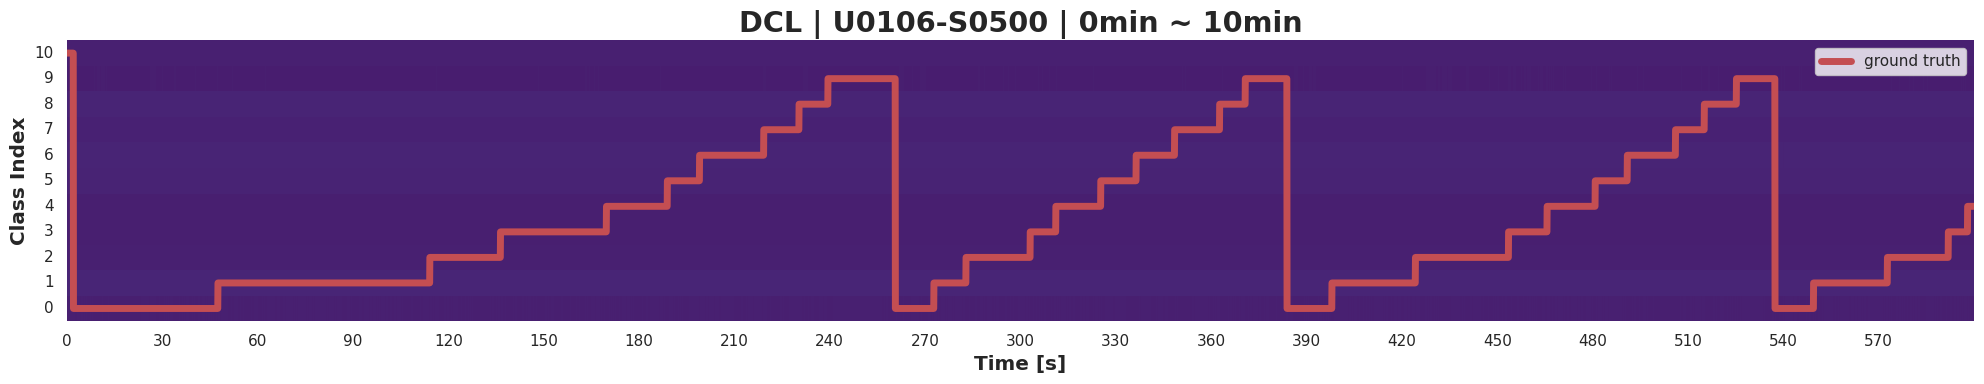

In [19]:
samples = (0, 10)

fig = plot_timeline(samples, t_idx, y_softmax, title_prefix=f"{cfg.model.name} | {key}")
fig.show()

ヒートマップの見方:

- 赤いライン: 正解ラベル
- 背景: 予測確率 (確率が高いところは黄色く表示される． 学習前はランダムな値しか出していないので，どのクラスも予測確率は低い.)
- 横軸: 時間
- 縦軸: 行動クラスのインデックス (1 = Picking[ID100], 2=Relocate Label[ID=200], ...)

ぜひ学習前のこの結果を覚えておいて頂き，学習後の結果と比較してみてください．

#### 6-4-2: 学習

In [20]:
logger.info(f"Start training for {num_epoch} epochs.")
trainer.fit(plmodel, datamodule)
logger.info("Finish training!")

2023-11-23 09:01:38 | INFO | __main__ | Start training for 50 epochs.
2023-11-23 09:01:39 | INFO | openpack_torch.data.datamodule | dataset[train]: OpenPackImu(index=533, num_sequence=15, submission=False, random_crop=True)
2023-11-23 09:01:39 | INFO | openpack_torch.data.datamodule | dataset[val]: {'U0106-S0200': <openpack_torch.data.datasets.OpenPackImu object at 0x7f079fc9fca0>, 'U0106-S0400': <openpack_torch.data.datasets.OpenPackImu object at 0x7f06cc73e1d0>}
2023-11-23 09:01:39 | INFO | openpack_torch.data.datamodule | dataset[test]: None
2023-11-23 09:01:39 | INFO | openpack_torch.data.datamodule | dataset[submission]: None
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2023-11-23 09:01:39 | INFO | openpack_torch.lightning | Adam optimizer is selected! (lr=0.001)
2023-11-23 09:01:39 | INFO | openpack_torch.lightning | StepLR scheduler is selected.

  | Name      | Type             | Params
-----------------------------------------------
0 | net       | DeepConvLstmV1   | 63.9 K
1 | c

Epoch 0: 100% 67/67 [00:00<00:00, 114.84it/s, v_num=3]          
Validation: |          | 0/? [00:00<?, ?it/s]
Validation:   0% 0/5 [00:00<?, ?it/s]        
Validation DataLoader 0:   0% 0/5 [00:00<?, ?it/s]
Validation DataLoader 0:  20% 1/5 [00:00<00:00, 129.37it/s]
Validation DataLoader 0:  40% 2/5 [00:00<00:00, 142.47it/s]
Validation DataLoader 0:  60% 3/5 [00:00<00:00, 148.75it/s]
Validation DataLoader 0:  80% 4/5 [00:00<00:00, 163.77it/s]
Validation DataLoader 0: 100% 5/5 [00:00<00:00, 161.29it/s]
Validation DataLoader 0:   0% 0/5 [00:00<?, ?it/s]         
Validation DataLoader 1:   0% 0/5 [00:00<?, ?it/s]
Validation DataLoader 1:  20% 1/5 [00:00<00:00, 137.55it/s]
Validation DataLoader 1:  40% 2/5 [00:00<00:00, 142.26it/s]
Validation DataLoader 1:  60% 3/5 [00:00<00:00, 164.93it/s]
Validation DataLoader 1:  80% 4/5 [00:00<00:00, 179.73it/s]
Validation DataLoader 1: 100% 5/5 [00:00<00:00, 183.96it/s]
Epoch 1: 100% 67/67 [00:00<00:00, 124.94it/s, v_num=3, val/loss/dataloader_idx_0=

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100% 67/67 [00:00<00:00, 92.64it/s, v_num=3, val/loss/dataloader_idx_0=2.160, val/acc/dataloader_idx_0=0.265, val/loss/dataloader_idx_1=2.140, val/acc/dataloader_idx_1=0.270, train/loss=1.280, train/acc=0.528]

2023-11-23 09:02:17 | INFO | __main__ | Finish training!


#### 6-4-5: 学習曲線の表示

モデルの学習がうまく行っているか確認するために，epochごとのlossの変化をプロットします．
lossがepochが進むにつれて徐々に下がっていくことを確認してください．

Training Log

In [21]:
pl_logdir = Path(cfg.path.logdir.rootdir, "lightning_logs/")
latest_logdir = list(sorted(pl_logdir.iterdir()))[-1]

df = pd.read_csv(Path(latest_logdir, "metrics.csv"))
df["phase"] = df["train/loss"].apply(lambda x: "val" if np.isnan(x) else "train")
df = df.set_index(["epoch", "phase"])

In [22]:
df.head()

step  val/loss/dataloader_idx_0  val/acc/dataloader_idx_0  val/loss/dataloader_idx_1  val/acc/dataloader_idx_1  train/loss  train/acc
epoch phase                                                                                                                                       
0     val      66                   2.025096                  0.253726                   1.988147                  0.269564         NaN        NaN
      train    66                        NaN                       NaN                        NaN                       NaN    1.942780   0.313548
1     val     133                   1.968024                  0.285152                   2.017458                  0.272831         NaN        NaN
      train   133                        NaN                       NaN                        NaN                       NaN    1.723472   0.364819
2     val     200                   2.052789                  0.270372                   2.039351                  0.281570         NaN        NaN

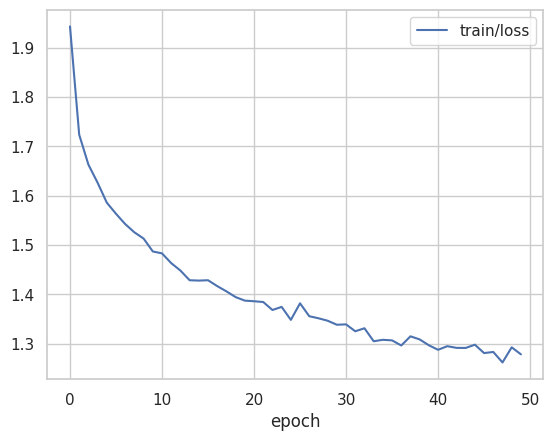

In [23]:
df.xs("train", level="phase")[["train/loss"]].plot()
plt.show()

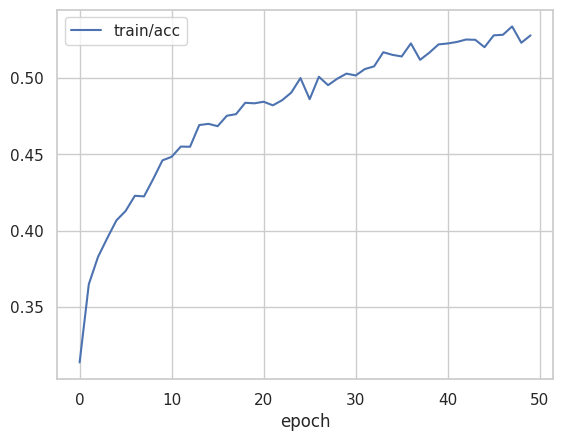

In [25]:
df.xs("train", level="phase")[["train/acc"]].plot()
plt.show()

### 6-5: 評価

In [27]:
# テストデータで評価
plmodel.clear_test_outputs()
datamodule.setup("test")

outputs, df_summary = test_helper(cfg, "test", datamodule, plmodel, trainer)

2023-11-23 09:04:30 | INFO | openpack_torch.data.datamodule | dataset[train]: None
2023-11-23 09:04:30 | INFO | openpack_torch.data.datamodule | dataset[val]: None
2023-11-23 09:04:30 | INFO | openpack_torch.data.datamodule | dataset[test]: {'U0106-S0100': <openpack_torch.data.datasets.OpenPackImu object at 0x7f06920de0b0>, 'U0106-S0300': <openpack_torch.data.datasets.OpenPackImu object at 0x7f0691f0ef80>, 'U0106-S0500': <openpack_torch.data.datasets.OpenPackImu object at 0x7f0691f64520>}
2023-11-23 09:04:30 | INFO | openpack_torch.data.datamodule | dataset[submission]: None
2023-11-23 09:04:30 | INFO | openpack_torch.utils.test_helper | test on U0106-S0100
2023-11-23 09:04:31 | INFO | openpack_torch.data.datamodule | dataset[train]: None
2023-11-23 09:04:31 | INFO | openpack_torch.data.datamodule | dataset[val]: None
2023-11-23 09:04:31 | INFO | openpack_torch.data.datamodule | dataset[test]: {'U0106-S0100': <openpack_torch.data.datasets.OpenPackImu object at 0x7f078a3169b0>, 'U0106-S

Testing DataLoader 0: 100% 7/7 [00:00<00:00, 228.94it/s]

2023-11-23 09:04:31 | INFO | openpack_torch.utils.test_helper | save t[shape=(50, 1800)] to /content/data/log/benchmark1/I01-EXP1-V1-nb/openpack-operations-1hz-annotation/pilot-challenge-split/atr02-iot/DCL/adam-exp/LR0.001/RUN0/pred/last/U0106-S0100/t.npy
2023-11-23 09:04:31 | INFO | openpack_torch.utils.test_helper | save y[shape=(50, 11, 1800)] to /content/data/log/benchmark1/I01-EXP1-V1-nb/openpack-operations-1hz-annotation/pilot-challenge-split/atr02-iot/DCL/adam-exp/LR0.001/RUN0/pred/last/U0106-S0100/y.npy
2023-11-23 09:04:31 | INFO | openpack_torch.utils.test_helper | save unixtime[shape=(50, 1800)] to /content/data/log/benchmark1/I01-EXP1-V1-nb/openpack-operations-1hz-annotation/pilot-challenge-split/atr02-iot/DCL/adam-exp/LR0.001/RUN0/pred/last/U0106-S0100/unixtime.npy
2023-11-23 09:04:31 | INFO | openpack_torch.utils.test_helper | test on U0106-S0300


2023-11-23 09:04:31 | INFO | openpack_torch.data.datamodule | dataset[train]: None
2023-11-23 09:04:31 | INFO | openpack_torch.data.datamodule | dataset[val]: None
2023-11-23 09:04:31 | INFO | openpack_torch.data.datamodule | dataset[test]: {'U0106-S0100': <openpack_torch.data.datasets.OpenPackImu object at 0x7f069222d390>, 'U0106-S0300': <openpack_torch.data.datasets.OpenPackImu object at 0x7f0691fd8f40>, 'U0106-S0500': <openpack_torch.data.datasets.OpenPackImu object at 0x7f0777efa260>}
2023-11-23 09:04:31 | INFO | openpack_torch.data.datamodule | dataset[submission]: None
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100% 5/5 [00:00<00:00, 209.83it/s]

2023-11-23 09:04:31 | INFO | openpack_torch.utils.test_helper | save t[shape=(85, 1800)] to /content/data/log/benchmark1/I01-EXP1-V1-nb/openpack-operations-1hz-annotation/pilot-challenge-split/atr02-iot/DCL/adam-exp/LR0.001/RUN0/pred/last/U0106-S0300/t.npy
2023-11-23 09:04:31 | INFO | openpack_torch.utils.test_helper | save y[shape=(85, 11, 1800)] to /content/data/log/benchmark1/I01-EXP1-V1-nb/openpack-operations-1hz-annotation/pilot-challenge-split/atr02-iot/DCL/adam-exp/LR0.001/RUN0/pred/last/U0106-S0300/y.npy
2023-11-23 09:04:31 | INFO | openpack_torch.utils.test_helper | save unixtime[shape=(85, 1800)] to /content/data/log/benchmark1/I01-EXP1-V1-nb/openpack-operations-1hz-annotation/pilot-challenge-split/atr02-iot/DCL/adam-exp/LR0.001/RUN0/pred/last/U0106-S0300/unixtime.npy
2023-11-23 09:04:31 | INFO | openpack_torch.utils.test_helper | test on U0106-S0500


2023-11-23 09:04:31 | INFO | openpack_torch.data.datamodule | dataset[train]: None
2023-11-23 09:04:31 | INFO | openpack_torch.data.datamodule | dataset[val]: None
2023-11-23 09:04:31 | INFO | openpack_torch.data.datamodule | dataset[test]: {'U0106-S0100': <openpack_torch.data.datasets.OpenPackImu object at 0x7f0777f2c910>, 'U0106-S0300': <openpack_torch.data.datasets.OpenPackImu object at 0x7f0777f5e320>, 'U0106-S0500': <openpack_torch.data.datasets.OpenPackImu object at 0x7f0777f936a0>}
2023-11-23 09:04:31 | INFO | openpack_torch.data.datamodule | dataset[submission]: None
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100% 3/3 [00:00<00:00, 154.30it/s]

2023-11-23 09:04:32 | INFO | openpack_torch.utils.test_helper | save t[shape=(103, 1800)] to /content/data/log/benchmark1/I01-EXP1-V1-nb/openpack-operations-1hz-annotation/pilot-challenge-split/atr02-iot/DCL/adam-exp/LR0.001/RUN0/pred/last/U0106-S0500/t.npy
2023-11-23 09:04:32 | INFO | openpack_torch.utils.test_helper | save y[shape=(103, 11, 1800)] to /content/data/log/benchmark1/I01-EXP1-V1-nb/openpack-operations-1hz-annotation/pilot-challenge-split/atr02-iot/DCL/adam-exp/LR0.001/RUN0/pred/last/U0106-S0500/y.npy
2023-11-23 09:04:32 | INFO | openpack_torch.utils.test_helper | save unixtime[shape=(103, 1800)] to /content/data/log/benchmark1/I01-EXP1-V1-nb/openpack-operations-1hz-annotation/pilot-challenge-split/atr02-iot/DCL/adam-exp/LR0.001/RUN0/pred/last/U0106-S0500/unixtime.npy
2023-11-23 09:04:32 | WARNING | openpack_toolkit.codalab.operation_segmentation.utils | 1 elements are missing from prediction.: [1637895693000]
2023-11-23 09:04:32 | WARNING | openpack_toolkit.codalab.operat

2023-11-23 09:04:32 | WARNING | openpack_toolkit.codalab.operation_segmentation.utils | 1 elements are missing from prediction.: [1637905740000]
2023-11-23 09:04:32 | WARNING | openpack_toolkit.codalab.operation_segmentation.utils | fill missing element at ts=1637905740000 (ind=2059) with 100.
2023-11-23 09:04:32 | WARNING | openpack_toolkit.codalab.operation_segmentation.utils | 1 elements are missing from prediction.: [1637911136000]
2023-11-23 09:04:32 | WARNING | openpack_toolkit.codalab.operation_segmentation.utils | fill missing element at ts=1637911136000 (ind=1030) with 100.
2023-11-23 09:04:32 | INFO | openpack_torch.utils.test_helper | write df_summary[shape=(96, 8)] to /content/data/log/benchmark1/I01-EXP1-V1-nb/openpack-operations-1hz-annotation/pilot-challenge-split/atr02-iot/DCL/adam-exp/LR0.001/RUN0/summary/last/test.csv
2023-11-23 09:04:32 | INFO | openpack_torch.utils.test_helper | df_summary:
                     name    id  precision    recall        f1 support      

#### 評価指標:

- Precision
- Recall
- F値 (F1-measure)

F値のマクロ平均 (f1, name=avg/macoro)に注目

In [28]:
df_summary[df_summary["key"]=="all"]

,name,id,precision,recall,f1,support,key,scenario
36,avg/macro,-1,0.248521,0.255870,0.228489,None,all,S1
37,avg/weighted,-1,0.252917,0.278900,0.246339,None,all,S1
38,Picking,100,0.228774,0.175725,0.198770,552,all,S1
39,Relocate Item Label,200,0.321027,0.425532,0.365965,940,all,S1
40,Assemble Box,300,0.352649,0.411197,0.379679,1036,all,S1
41,Insert Items,400,0.200158,0.517382,0.288648,489,all,S1
42,Close Box,500,0.234142,0.376877,0.288838,666,all,S1
43,Attach Box Label,600,0.236641,0.087079,0.127310,356,all,S1
44,Scan Label,700,0.000000,0.000000,0.000000,680,all,S1
45,Attach Shipping Label,800,0.377451,0.166667,0.231231,462,all,S1


#### 可視化

In [29]:
# 可視化したいセグメント
key = "U0106-S0500"

# 予測結果の取得
unixtimes = outputs[key]["unixtime"] 
t_idx = outputs[key]["t_idx"]
y = outputs[key]["y"]
y_softmax = softmax(y, axis=1)
print(f"unixtimes={unixtimes.shape}, t_idx={t_idx.shape}, y={y.shape}, y_softmax={y_softmax.shape}")

unixtimes=(103, 1800), t_idx=(103, 1800), y=(103, 11, 1800), y_softmax=(103, 11, 1800)


prob=(11, 18000) pred=(18000,), gt=(18000,)


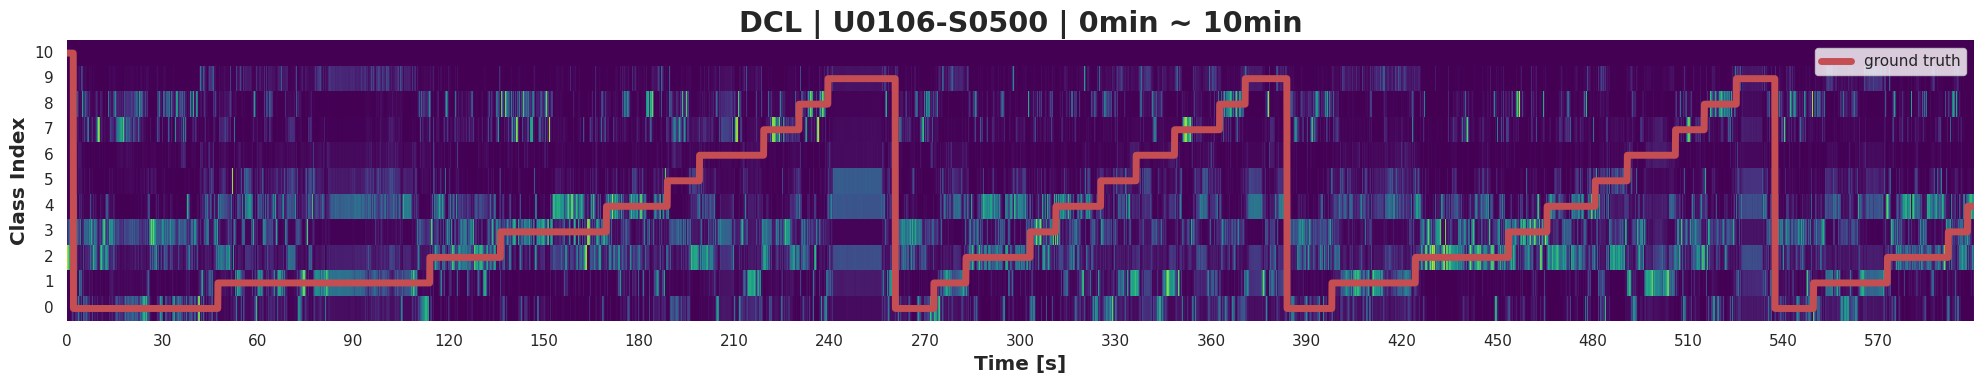

In [30]:
samples = (0, 10)

fig = plot_timeline(samples, t_idx, y_softmax, title_prefix=f"{cfg.model.name} | {key}")
fig.show()

学習前の図と比べて，出力はどうなったでしょうか？
赤い正解ラベルの付近が黄色くなっているかと思います．モデリングを工夫すると90%近くまでスコアが上がると思います．様々なモデルとパラメータをトライしてみてください．